In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import np_utils

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf

import cv2
import os

import numpy as np

In [119]:
labels = ['up_arrow', 'left_arrow']

def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                # Read in and set to grayscale
                img_arr = cv2.cvtColor(cv2.imread(os.path.join(path, img)), cv2.COLOR_BGR2GRAY)
                data.append([img_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [120]:
data = get_data('processed-images')

<ipython-input-119-95631b8dcf76>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


C:\Users\johna\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

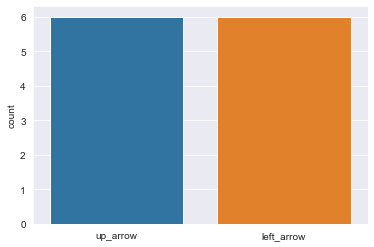

In [121]:
l = []
for i in data:
    if(i[1] == 0):
        l.append("up_arrow")
    else:
        l.append("left_arrow")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'up_arrow')

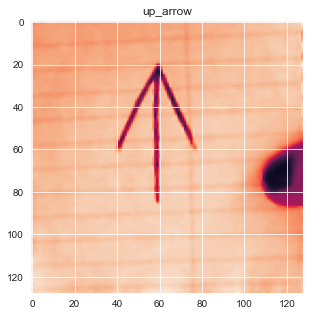

In [122]:
plt.figure(figsize = (5,5))
plt.imshow(data[1][0])
plt.title(labels[data[0][1]])

Text(0.5, 1.0, 'left_arrow')

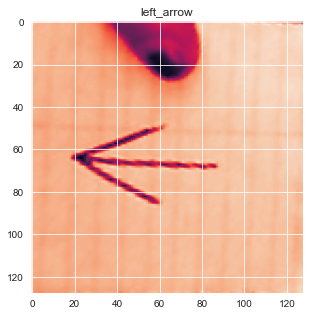

In [123]:
plt.figure(figsize = (5,5))
plt.imshow(data[-1][0])
plt.title(labels[data[-1][1]])

In [124]:
# Split into a training and validation set
X = []
y = []

for feature, label in data:
  X.append(feature)
  y.append(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [130]:
# Normalize the data
X_train = np.array(X_train) / 255
X_test = np.array(X_test) / 255
#X_train = X_train.reshape(X_train.shape[0], 128*128)
#X_test = X_test.reshape(X_test.shape[0], 128*128)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9, 16384)
(9,)
(3, 16384)
(3,)


In [131]:
# TODO:
# Make images much more clear, sharpen center symbol and attempt to make background completely blank

In [132]:
# One-hot encoding
n_classes = 2
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (9,)
Shape after one-hot encoding:  (9, 2)


In [140]:
# Building a linear stack of layers with the sequential model
model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(128,128,1)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
# hidden layer
model.add(Dense(100, activation='relu'))
# output layer
model.add(Dense(10, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [141]:
# training the model for 10 epochs
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10


ValueError: in user code:

    C:\Users\johna\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\johna\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\johna\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\johna\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\johna\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\johna\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\johna\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Users\johna\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\johna\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:234 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_20 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (None, 16384)
